In [74]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median', 'axes', 'choice', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [75]:
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()
from Chempy.cem_function import single_timestep_chempy

## Load the data

In [4]:
# Define elements to use:

els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements

# Load training data:
full_input = '/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Training_Data_TNG_500000_0_v3.npz'
dat1=np.load(full_input,mmap_mode='r')
full_input2 = '/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Training_Data_TNG_500000_1_v3.npz'
dat2=np.load(full_input2,mmap_mode='r')


all_els = dat1['elements']
for e in range(len(all_els)):
    assert dat1['elements'][e]==dat2['elements'][e]
    
#params = dat1['params']#[:100000]
params=np.concatenate([dat1['params'],dat2['params']])
#big_abun = dat1.f.abundances#[:100000]
big_abun=np.concatenate([dat1.f.abundances,dat2.f.abundances])

el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    el_indices[e]=np.where(el==all_els)[0]
    
# Filter out unwanted elements
abun = big_abun[:,el_indices]


## Remove any bad runs
bitmap=np.ones(len(params),dtype=int)
for i,ab in enumerate(abun):
    if ab[0]==0:
        bitmap[i]=0

cut_params=params[np.where(bitmap==1)]
cut_abuns=abun[np.where(bitmap==1)]

good_index=np.where(np.isfinite(cut_abuns).all(axis=1))[0] # remove infinities
cut_params2=cut_params[good_index]
cut_abuns2=cut_abuns[good_index]
good_index2=np.where(cut_params2[:,-1]>0.99)[0] # remove bad birth times
cut_params3=cut_params2[good_index2]
cut_abuns3=cut_abuns2[good_index2]

# Set standardization parameters
par_mean=np.mean(cut_params3,axis=0)
par_std=np.std(cut_params3,axis=0)
ab_mean=np.mean(cut_abuns3,axis=0)
ab_std=np.std(cut_abuns3,axis=0)

# Change birth-time mean/std to give t in [0,1] - we use (T-mean_T)/std_T here so this works
par_mean[-1]=min(cut_params3[:,-1])
par_std[-1]=(max(cut_params3[:,-1])-min(cut_params3[:,-1]))

# Now randomize the selection
len_filt=np.random.choice(range(len(cut_abuns3)),replace=False,size=len(cut_abuns3))

# Create randomized and standardized training data
trainX=(cut_params3[len_filt]-par_mean)/par_std
trainY=(cut_abuns3[len_filt]-ab_mean)/ab_std

# Add in T^2 term for accuracy
n_poly=2
sq_trainX=np.zeros([trainX.shape[0],trainX.shape[1]+n_poly-1])#+2])
sq_trainX[:,:trainX.shape[1]]=trainX
for i in range(n_poly-1):
    sq_trainX[:,trainX.shape[1]+i]=trainX[:,-1]**(i+2)

print('Using %d training data points for a %d->%d shape network'%(sq_trainX.shape[0],sq_trainX.shape[1],trainY.shape[1]))

Using 916577 training data points for a 7->8 shape network


In [5]:
# Load test data:
datT=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Random_Test_Data_TNG_50000_0_v3.npz')
abunT=datT.f.abundances[:,el_indices]
elsT=datT.f.elements
paramsT=datT.f.params

bitmapT=np.ones(len(paramsT),dtype=int)
for i,ab in enumerate(abunT):
    if ab[0]==0:
        bitmapT[i]=0
                
# Remove dodgy data
cut_paramsT=paramsT[np.where(bitmapT==1)]
cut_abunsT=abunT[np.where(bitmapT==1)]
good_indexT=np.where((np.isfinite(cut_abunsT).all(axis=1)))
cut_params2T=cut_paramsT[good_indexT]
cut_abuns2T = cut_abunsT[good_indexT]
good_index2T=np.where(cut_params2T[:,-1]>0.99)
cut_params3T=cut_params2T[good_index2T]
cut_abuns3T = cut_abuns2T[good_index2T]
                     
# Standardize using same standardizations as before
testX=(cut_params3T-par_mean)/par_std
testY=(cut_abuns3T-ab_mean)/ab_std

sq_testX=np.zeros([testX.shape[0],testX.shape[1]+n_poly-1])#+2])
sq_testX[:,:testX.shape[1]]=testX
for i in range(n_poly-1):
    sq_testX[:,testX.shape[1]+i]=testX[:,-1]**(i+2)

print("Using %d test data points"%sq_testX.shape[0])

Using 45771 test data points


## Create the network in scikit-learn

In [6]:
from sklearn import cross_validation
from sklearn.neural_network import MLPRegressor

def single_regressor(neurons,el_index,epochs=1000,verbose=True):
    """Return out-of-sample score for a given number of neurons for one element"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=epochs,learning_rate='adaptive',tol=1e-13,
                       hidden_layer_sizes=(neurons,),activation='tanh',verbose=verbose,
                      shuffle=True,early_stopping=True)#,learning_rate_init=0.1)

    model.fit(sq_trainX,trainY[:,el_index])

    model_pred=model.predict(sq_testX)
    score = np.mean((model_pred-testY[:,el_index])**2.)
    diff = np.abs(testY[:,el_index]-model_pred)
    w0,w1=model.coefs_
    b0,b1=model.intercepts_
    return score,diff,[w0,w1,b0,b1]

def all_regressor(neurons,epochs=1000,verbose=True):
    """Return out-of-sample score for a given number of neurons for all elements"""
    model=MLPRegressor(solver='adam',alpha=0.001,max_iter=epochs,learning_rate='adaptive',tol=1e-13,
                       hidden_layer_sizes=(neurons,),activation='tanh',verbose=verbose,
                      shuffle=True,early_stopping=True)#,learning_rate_init=0.1)

    model.fit(sq_trainX,trainY)

    model_pred=model.predict(sq_testX)
    scores = np.mean((model_pred-testY)**2.,axis=0)
    diffs = np.abs(testY-model_pred)
    w0,w1=model.coefs_
    b0,b1=model.intercepts_
    return scores,diffs,[w0,w1,b0,b1]


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Run single neuron nets for various $n_\mathrm{neuron}$

In [28]:
def neural_run(nn):
    print("Running for %d neurons"%nn)
    return single_regressor(nn,0)[0]
import multiprocessing as mp
import tqdm
p=mp.Pool()
all_neurons = np.arange(5,85,5)
neuron_scores=list(tqdm.tqdm(p.imap(neural_run,all_neurons),total=len(all_neurons)))

  0%|          | 0/16 [00:00<?, ?it/s]

Running for 5 neurons
Running for 10 neurons
Running for 25 neurons
Running for 35 neurons
Running for 50 neurons
Running for 40 neurons
Running for 30 neurons
Running for 15 neurons
Running for 20 neurons
Running for 60 neurons
Running for 45 neurons
Running for 55 neurons
Running for 65 neurons
Running for 80 neurons
Running for 70 neurons
Running for 75 neurons
Iteration 1, loss = 0.04839618
Validation score: 0.985900
Iteration 1, loss = 0.01546698
Validation score: 0.992928
Iteration 1, loss = 0.09010115
Validation score: 0.982979
Iteration 1, loss = 0.04006308
Validation score: 0.990443
Iteration 1, loss = 0.02371209
Validation score: 0.992438
Iteration 1, loss = 0.01676570
Iteration 1, loss = 0.01389598
Validation score: 0.993724
Iteration 1, loss = 0.02045159
Validation score: 0.993696
Validation score: 0.992712
Iteration 1, loss = 0.01875467
Validation score: 0.993928
Iteration 2, loss = 0.00672555
Validation score: 0.988037
Iteration 1, loss = 0.02002688
Validation score: 0.99

Iteration 7, loss = 0.00103397
Validation score: 0.998308
Iteration 10, loss = 0.00089516
Validation score: 0.998619
Iteration 7, loss = 0.00098777
Validation score: 0.998371
Iteration 12, loss = 0.00158124
Validation score: 0.997178
Iteration 15, loss = 0.00450935
Validation score: 0.991028
Iteration 8, loss = 0.00096943
Validation score: 0.998494
Iteration 11, loss = 0.00117528
Validation score: 0.997826
Iteration 7, loss = 0.00099281
Validation score: 0.998460
Iteration 12, loss = 0.00141759
Validation score: 0.997527
Iteration 14, loss = 0.00215899
Validation score: 0.995865
Iteration 8, loss = 0.00095257
Iteration 10, loss = 0.00101728
Validation score: 0.998414
Validation score: 0.998360
Iteration 7, loss = 0.00093593
Validation score: 0.998532
Iteration 9, loss = 0.00102243
Validation score: 0.998200
Iteration 7, loss = 0.00098179
Validation score: 0.998195
Iteration 16, loss = 0.00449261
Validation score: 0.991210
Iteration 11, loss = 0.00087606
Iteration 13, loss = 0.00154298


Validation score: 0.998752
Iteration 21, loss = 0.00101101
Validation score: 0.998324
Iteration 15, loss = 0.00084516
Validation score: 0.998673
Iteration 29, loss = 0.00437298
Validation score: 0.991399
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


  6%|▋         | 1/16 [06:16<1:34:12, 376.84s/it]

Iteration 14, loss = 0.00077121
Validation score: 0.998907
Iteration 24, loss = 0.00138478
Validation score: 0.997528
Iteration 14, loss = 0.00078558
Validation score: 0.998892
Iteration 21, loss = 0.00078656
Validation score: 0.998842
Iteration 13, loss = 0.00080765
Validation score: 0.998761
Iteration 15, loss = 0.00080509
Validation score: 0.998783
Iteration 23, loss = 0.00129434
Validation score: 0.997684
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 17, loss = 0.00079969
Iteration 22, loss = 0.00100390
Validation score: 0.998339
Validation score: 0.998845
Iteration 17, loss = 0.00085966
Validation score: 0.998657
Iteration 15, loss = 0.00078776
Validation score: 0.998814
Iteration 15, loss = 0.00080807
Validation score: 0.998810
Iteration 25, loss = 0.00138167
Validation score: 0.997584
Iteration 16, loss = 0.00084110
Validation score: 0.998693
Iteration 22, loss = 0.00078389
Validation score: 0.998872
Iteration 15, loss = 

 19%|█▉        | 3/16 [07:55<1:00:21, 278.58s/it]

Iteration 27, loss = 0.00098027
Validation score: 0.998317
Iteration 19, loss = 0.00077327
Validation score: 0.998684
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 19, loss = 0.00075292
Validation score: 0.998910
Iteration 20, loss = 0.00082365
Validation score: 0.998737
Iteration 22, loss = 0.00076848
Validation score: 0.998867
Iteration 28, loss = 0.00097712
Validation score: 0.998322
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


 31%|███▏      | 5/16 [08:08<36:06, 196.96s/it]  

Iteration 19, loss = 0.00076696
Validation score: 0.998894
Iteration 19, loss = 0.00071915
Validation score: 0.999027
Iteration 17, loss = 0.00075986
Validation score: 0.998908
Iteration 22, loss = 0.00080814
Iteration 20, loss = 0.00074657
Validation score: 0.998684
Validation score: 0.998836
Iteration 23, loss = 0.00076380
Validation score: 0.998925
Iteration 28, loss = 0.00075698
Validation score: 0.998981
Iteration 21, loss = 0.00081806
Iteration 20, loss = 0.00071612
Validation score: 0.998691
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Validation score: 0.999019
Iteration 21, loss = 0.00073960
Validation score: 0.998777
Iteration 23, loss = 0.00080219
Validation score: 0.998804
Iteration 24, loss = 0.00075941
Validation score: 0.998913
Iteration 21, loss = 0.00071050
Validation score: 0.999088
Iteration 22, loss = 0.00073498
Validation score: 0.998937
Iteration 29, loss = 0.00075670
Validation score: 0.998875
Iteration 25, loss = 

 44%|████▍     | 7/16 [10:00<23:11, 154.63s/it]

Iteration 25, loss = 0.00073358
Validation score: 0.999001
Iteration 32, loss = 0.00073279
Validation score: 0.998897
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 23, loss = 0.00071657


 62%|██████▎   | 10/16 [10:03<10:51, 108.54s/it]

Validation score: 0.999094
Iteration 29, loss = 0.00068186
Validation score: 0.999120
Iteration 30, loss = 0.00067956
Validation score: 0.999057
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 26, loss = 0.00072830
Validation score: 0.998960
Iteration 24, loss = 0.00071159
Validation score: 0.999100
Iteration 27, loss = 0.00072438
Validation score: 0.998910
Iteration 25, loss = 0.00070561
Validation score: 0.999076
Iteration 28, loss = 0.00072071
Validation score: 0.999057
Iteration 26, loss = 0.00070289
Validation score: 0.999073
Iteration 29, loss = 0.00071825
Validation score: 0.998945
Iteration 27, loss = 0.00069745
Validation score: 0.999028
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.
Iteration 30, loss = 0.00071469
Validation score: 0.998885
Iteration 31, loss = 0.00071240
Validation score: 0.998986
Validation score did not improve more than tol=0.000000 for two consecutive e

100%|██████████| 16/16 [10:22<00:00, 38.91s/it] 


In [29]:
np.savez('8element_net_variable_neurons_L2_scores_v3',neurons=all_neurons,scores=neuron_scores)

In [30]:
d=np.load('8element_net_variable_neurons_L2_scores_v3.npz')
all_neurons=d['neurons']
neuron_scores=d['scores']

(0.0004, 0.1)

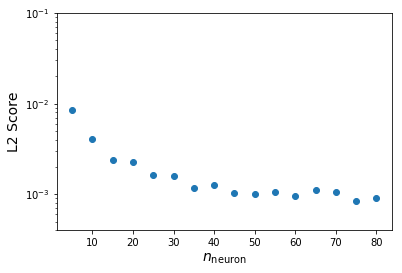

In [31]:
plt.scatter(all_neurons,neuron_scores);plt.ylabel('L2 Score',fontsize=14);
plt.xlabel(r'$n_\mathrm{neuron}$',fontsize=14);
plt.yscale('log')
plt.ylim([4e-4,1e-1])

## Now train networks in parallel using $n_\mathrm{neuron}=40$:

In [7]:
neurons=40
def mp_run(el_i):
    print("Running net %d of %d"%(int(el_i)+1,len(els)))
    output = single_regressor(neurons,int(el_i),epochs=3000)
    return output

In [8]:
import multiprocessing as mp
p=mp.Pool()
import tqdm
output=list(tqdm.tqdm(p.imap(mp_run,range(len(els))),total=len(els)))

  0%|          | 0/8 [00:00<?, ?it/s]

Running net 1 of 8
Running net 3 of 8
Running net 4 of 8
Running net 2 of 8
Running net 5 of 8
Running net 6 of 8
Running net 7 of 8
Running net 8 of 8
Iteration 1, loss = 0.02002497
Iteration 1, loss = 0.01776068
Validation score: 0.994353
Validation score: 0.997216
Iteration 1, loss = 0.02252152
Validation score: 0.996837
Iteration 1, loss = 0.01813002
Iteration 1, loss = 0.01914134
Validation score: 0.997459
Iteration 1, loss = 0.01718709
Validation score: 0.989879
Validation score: 0.998307
Iteration 1, loss = 0.02399559
Validation score: 0.992832
Iteration 1, loss = 0.03253910
Validation score: 0.992110
Iteration 2, loss = 0.00209843
Validation score: 0.997074
Iteration 2, loss = 0.00116561
Validation score: 0.998206
Iteration 2, loss = 0.00106769
Validation score: 0.998391
Iteration 2, loss = 0.00267370
Iteration 2, loss = 0.00116543
Validation score: 0.996437
Validation score: 0.998390
Iteration 2, loss = 0.00069057
Validation score: 0.999001
Iteration 2, loss = 0.00282085
Valid

Iteration 17, loss = 0.00029301
Validation score: 0.999503
Iteration 17, loss = 0.00086004
Validation score: 0.998604
Iteration 21, loss = 0.00083369
Validation score: 0.998779
Iteration 17, loss = 0.00047540
Validation score: 0.999209
Iteration 17, loss = 0.00181116
Validation score: 0.996805
Iteration 21, loss = 0.00037239
Validation score: 0.999473
Iteration 17, loss = 0.00089684
Validation score: 0.998666
Iteration 18, loss = 0.00029097
Validation score: 0.999535
Iteration 22, loss = 0.00082813
Validation score: 0.998781
Iteration 18, loss = 0.00085383
Validation score: 0.998666
Iteration 18, loss = 0.00047337
Validation score: 0.999226
Iteration 18, loss = 0.00178625
Validation score: 0.997099
Iteration 22, loss = 0.00037007
Validation score: 0.999450
Iteration 18, loss = 0.00089040
Validation score: 0.998577
Iteration 23, loss = 0.00082235
Validation score: 0.998771
Iteration 19, loss = 0.00084320
Validation score: 0.998665
Iteration 19, loss = 0.00028853
Validation score: 0.9995

 12%|█▎        | 1/8 [02:16<15:55, 136.54s/it]

Iteration 26, loss = 0.00045500
Validation score: 0.999279
Iteration 26, loss = 0.00168678
Validation score: 0.997294
Iteration 27, loss = 0.00045264
Validation score: 0.999222
Iteration 27, loss = 0.00167259
Validation score: 0.997374
Iteration 28, loss = 0.00045025
Validation score: 0.999311
Iteration 28, loss = 0.00166443
Validation score: 0.997322
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


 25%|██▌       | 2/8 [02:23<09:45, 97.58s/it] 

Iteration 29, loss = 0.00044882
Validation score: 0.999273
Iteration 30, loss = 0.00044792
Validation score: 0.999331
Iteration 31, loss = 0.00044513
Validation score: 0.999283
Iteration 32, loss = 0.00044302
Validation score: 0.999312
Iteration 33, loss = 0.00044265
Validation score: 0.999321
Validation score did not improve more than tol=0.000000 for two consecutive epochs. Stopping.


100%|██████████| 8/8 [02:34<00:00, 19.33s/it]


In [9]:
all_scores = np.zeros(len(els))
all_diffs = np.zeros([len(els),len(testY)])
coeffs=[]
for el_i in range(len(els)):
    all_scores[el_i],all_diffs[el_i],co=output[el_i]
    coeffs.append(co)

In [10]:
w0=np.hstack([co[0] for co in coeffs])
b0=np.hstack([co[2] for co in coeffs])
b1=np.hstack([co[3] for co in coeffs])

## Read in w1 vector into sparse structure
w1=np.zeros([w0.shape[1],b1.shape[0]])
assert neurons==w0.shape[1]/len(coeffs)
for i in range(len(coeffs)):
    w1[int(neurons*i):int(neurons*(i+1)),i]=coeffs[i][1][:,0]
    


In [11]:
def stacked_net_output(in_par):
    l1=np.matmul(in_par,w0)+b0
    return np.matmul(np.tanh(l1),w1)+b1

In [12]:
# Save output
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/stacked_8_element_net_v3.npz',w0=w0,w1=w1,b0=b0,b1=b1,
         in_mean=par_mean,in_std=par_std,out_mean=ab_mean,out_std=ab_std,
         activation='tanh',neurons=neurons)

In [13]:
# Reload data
dat=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/stacked_8_element_net_v3.npz')
w0=dat['w0'];w1=dat['w1'];b0=dat['b0'];b1=dat['b1']

In [14]:
l1_err = np.abs(stacked_net_output(sq_testX)-testY)

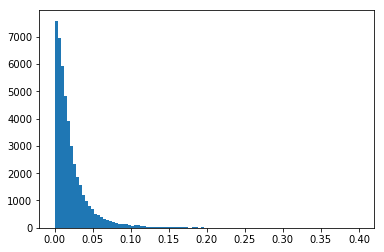

In [15]:
plt.hist(l1_err[:,2],range=[0,.4],bins=100);

## Run for all networks together:

In [16]:
comb_scores,comb_diffs,_ = all_regressor(40,epochs=3000)

Iteration 1, loss = 0.02091465
Validation score: 0.991372
Iteration 2, loss = 0.00337919
Validation score: 0.994962
Iteration 3, loss = 0.00254510
Validation score: 0.995916
Iteration 4, loss = 0.00227342
Validation score: 0.996238
Iteration 5, loss = 0.00213937
Validation score: 0.996637
Iteration 6, loss = 0.00203251
Validation score: 0.996871
Iteration 7, loss = 0.00193124
Validation score: 0.997049
Iteration 8, loss = 0.00184770
Validation score: 0.997243
Iteration 9, loss = 0.00177851
Validation score: 0.997355
Iteration 10, loss = 0.00172325
Validation score: 0.997457
Iteration 11, loss = 0.00167709
Validation score: 0.997498
Iteration 12, loss = 0.00164366
Validation score: 0.997634
Iteration 13, loss = 0.00161787
Validation score: 0.997680
Iteration 14, loss = 0.00159862
Validation score: 0.997746
Iteration 15, loss = 0.00158237
Validation score: 0.997723
Iteration 16, loss = 0.00156866
Validation score: 0.997746
Iteration 17, loss = 0.00155459
Validation score: 0.997811
Iterat

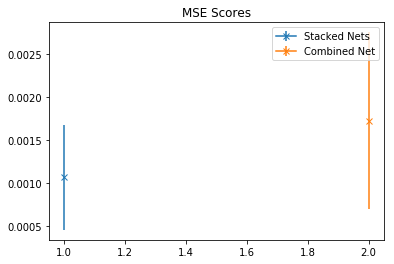

In [17]:
plt.errorbar(1,np.mean(all_scores),yerr=np.std(all_scores),marker='x',label='Stacked Nets')
plt.errorbar(2,np.mean(comb_scores),yerr=np.std(comb_scores),marker='x',label='Combined Net')
plt.legend();plt.title('MSE Scores');

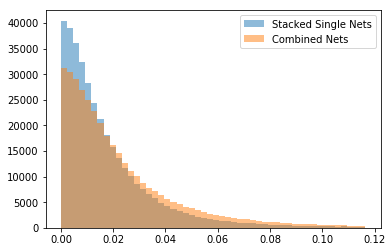

In [18]:
plt.hist(all_diffs.ravel(),range=[0,np.percentile(all_diffs.ravel(),99)],alpha=0.5,bins=50,label='Stacked Single Nets');
plt.hist(comb_diffs.ravel(),range=[0,np.percentile(all_diffs.ravel(),99)],alpha=0.5,bins=50,label='Combined Nets');
plt.legend();

In [19]:
## Compute L1 differences for combined and stacked nets (with correct normalizations)
real_all_diffs = np.asarray([ad*ab_std for ad in all_diffs.T])
real_comb_diffs = np.asarray([cd*ab_std for cd in comb_diffs])

In [21]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/Training_plot_data_v3.npz',
        real_all_diffs=real_all_diffs,
        real_comb_diffs=real_comb_diffs,
        els=els)

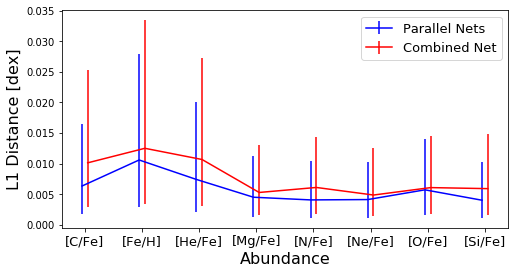

In [44]:
def percs(data,axis=0):
    percs=np.percentile(data,[15.865,50.,100.-15.865],axis=axis)
    return percs[1],percs[1]-percs[0],percs[2]-percs[1]
all_percs=percs(real_all_diffs)
comb_percs=percs(real_comb_diffs)


plt.figure(figsize=(8,4))
plt.errorbar(np.arange(len(els))-0.05,all_percs[0],
             yerr=[all_percs[1],all_percs[2]],label='Parallel Nets',c='b');
plt.errorbar(np.arange(len(els))+0.05,comb_percs[0],
             yerr=[comb_percs[1],comb_percs[2]],label='Combined Net',c='r');FS=16
plt.legend(fontsize=13);plt.ylabel('L1 Distance [dex]',fontsize=FS);
plt.xlabel('Abundance',fontsize=FS)

names = []
for el in els:
    if el!='Fe':
        names.append('[%s/Fe]'%el)
    else:
        names.append('[Fe/H]')

plt.xticks(range(8),names,fontsize=13);
plt.savefig('Plots_New/L1_Element_Error_v3.pdf',bbox_inches='tight')

In [40]:
p1,p2,p3=np.percentile(real_all_diffs,[15.865,50.,100-17.865])

In [41]:
print(r'$%.3f_{-%.3f}^{+%.3f}$'%(p2,p2-p1,p3-p2))

$0.005_{-0.004}^{+0.008}$


In [26]:
print("Single Stacked Nets",np.mean(real_all_diffs).round(3),np.std(real_all_diffs).round(3))

Single Stacked Nets 0.009 0.013


In [27]:
print("Combined Nets",np.mean(real_comb_diffs).round(3),np.std(real_comb_diffs).round(3))

Combined Nets 0.011 0.016


### So the single nets seem to perform better here.

## Now access the convergence across parameter space:

#### Using mean L1 error here:

In [46]:
train_par = cut_params3
test_par=cut_params3T
stacked_pred =stacked_net_output(sq_testX)
stacked_diff = np.mean(np.abs((stacked_pred-testY)*ab_std),axis=1) # destandardize here

In [49]:
ax=axes[1,2]

In [76]:
all_low = [-4,-5,-3,0.294,0,1]
all_high = [-1,-1,2,1,1,13.8]

<Figure size 432x288 with 0 Axes>

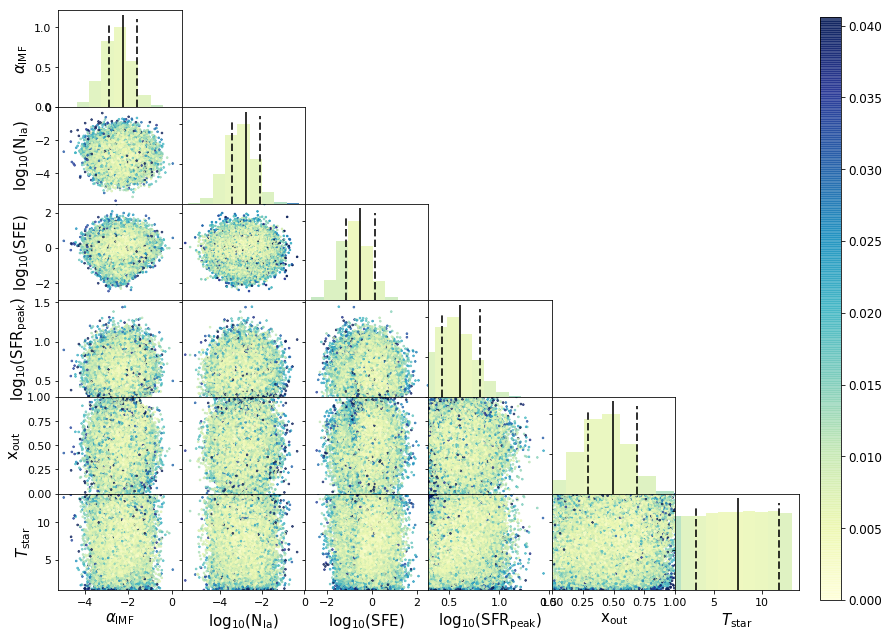

In [80]:
data_tr = train_par
data_v = test_par
param_error = stacked_diff

# Initialize plot
plt.clf()
text_size = 12

#plt.rc('text', usetex=False)
#plt.rc('font', family='sans-serif')

#plt.rc('font', family='serif',size = text_size)
#plt.rc('xtick', labelsize=text_size)
#plt.rc('ytick', labelsize=text_size)
#plt.rc('axes', labelsize=text_size, lw=1.0)
#plt.rc('lines', linewidth = 1)
#plt.rcParams['ytick.major.pad']='8'
#plt.rcParams['text.latex.preamble']=[r"\usepackage{libertine}"]
#params = {'text.usetex' : True,
#      'font.family' : 'libertine',
#      'text.latex.unicode': True,
#      }
#plt.rcParams.update(params)
parameter_names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}(\mathrm{N_{Ia}})$',
               r'$\log_{10}(\mathrm{SFE})$',
               r'$\log_{10}(\mathrm{SFR_{peak}})$',r'$\mathrm{x}_\mathrm{out}$',r'$T_\mathrm{star}$']


# Plot settings
fig,axes = plt.subplots(nrows = 6, ncols = 6,figsize=(14.69,9.0))#,dpi=300)
alpha = 0.8
lw=2 # Linewidth
left = 0.1 # Left side of subplots
right = 0.8 # Right side
bottom = 0.075
top = 0.97
wspace = 0.0 # blankspace width between subplots
hspace = 0.0 # blankspace height between subplots
color_max = np.percentile(param_error,99.)#0.05#a.color_max
plt.subplots_adjust(left=left,bottom=bottom,right=right,top=top,wspace=wspace,hspace=hspace)

cmap= cm.YlGnBu

# Create plot
for i in range(6):
    for j in range(6):
        axes[i,j].locator_params(nbins=4)
        axes[i,j].xaxis.set_tick_params(labelsize=11)
        axes[i,j].yaxis.set_tick_params(labelsize=11)
        if j==1:
            axes[i,j].locator_params(nbins=4)
        if i==j:
            counts,edges = np.histogram(np.asarray(data_v[:,j]),bins=10)
            max_count = float(np.max(counts))
            counts = np.divide(counts,max_count)
            median = np.zeros(len(edges)-1)
            for k in range(len(edges)-1):
                choice = np.logical_and(np.greater(data_v[:,j],edges[k]),np.less(data_v[:,j],edges[k+1]))
                error=np.extract(choice,param_error)
                if len(error) != 0:
                    median[k] = np.median(error)
            colors = cmap(median/color_max)
            axes[i,j].bar(x = edges[:-1], height=counts, width = edges[1]-edges[0],
                                color=colors,alpha=alpha, linewidth=0,rasterized=True)
            axes[i,j].set_xlim(all_low[j],all_high[j])
            axes[i,j].set_xlim(min(data_v[:,j]),max(data_v[:,j]))
            if j==4:
                axes[i,j].set_xlim(0,1)
            #axes[i,j].set_ylim(0,1.05)
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            axes[i,j].vlines(np.percentile(data_v[:,j],15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],100-15.865),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw,linestyle = 'dashed')
            axes[i,j].vlines(np.percentile(data_v[:,j],50),axes[i,j].get_ylim()[0],axes[i,j].get_ylim()[1], color = 'k',alpha=alpha,linewidth = lw)
        if i>j:
            if j !=0:
                plt.setp(axes[i,j].get_yticklabels(), visible=False)
            P1 = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='x',alpha=alpha,
                                    c=param_error,vmin=0,vmax=color_max,cmap=cmap,s=3,rasterized=True)
            #P2 = axes[i,j].scatter(data_tr[:,j],data_tr[:,i],c='k',marker='+',s=80)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
            #axes[i,j].set_xlim(all_low[j],all_high[j])
            #axes[i,j].set_ylim(all_low[i],all_high[i])
            if j==4:
                axes[i,j].set_xlim(0,1)
            if i==4:
                axes[i,j].set_ylim(0,1)
        if j>i:
            axes[i,j].axis('off')
        if i == 5:
            axes[i,j].set_xlabel(parameter_names[j],fontsize=15)
        if j ==0:
            axes[i,j].set_ylabel(parameter_names[i],fontsize=15)
        if i==2 and j == 1:
            cplot = axes[i,j].scatter(data_v[:,j],data_v[:,i],marker='.',alpha=alpha,
                                                c=param_error,vmin=0,vmax=color_max,
                                                cmap=cmap,s=3,rasterized=True)
            axes[i,j].set_xlim(min(data_tr[:,j]),max(data_tr[:,j]))
            axes[i,j].set_ylim(min(data_tr[:,i]),max(data_tr[:,i]))
cax=fig.add_axes([0.82,0.06,0.02,0.9]);
cbar=plt.colorbar(cplot,cax=cax);
cbar.ax.tick_params(labelsize=12)
#plt.savefig('Plots/Network_Error_Param_Space.pdf',bbox_inches='tight')

plt.show();


In [81]:
fig.savefig('Plots_New/Network_Error_Param_Space_v3.png',dpi=300,bbox_inches='tight')#,dpi=50)